# Bonus Assignment 1 - Obtain More Accurate Locations

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import Point, LineString
from sklearn.cluster import DBSCAN

In [2]:
# import the roads shapefile
roads = gpd.read_file('roads.shp')
print(roads.keys())
roads.head()

Index(['osm_id', 'name', 'ref', 'type', 'oneway', 'bridge', 'maxspeed',
       'geometry'],
      dtype='object')


,osm_id,name,ref,type,oneway,bridge,maxspeed,geometry
0,8656088,Park Rd,None,residential,0,0,NaN,"LINESTRING (90.42258 23.79758, 90.42238 23.798..."
1,8656089,Embassy Rd,None,residential,0,0,NaN,"LINESTRING (90.41891 23.79768, 90.42034 23.798..."
2,8656151,Dutabash Rd,None,residential,0,0,NaN,"LINESTRING (90.41857 23.79918, 90.41941 23.799..."
3,8656152,Road 1,None,residential,0,0,NaN,"LINESTRING (90.41926 23.80001, 90.42059 23.800..."
4,8656154,Road 2,None,residential,0,0,NaN,"LINESTRING (90.42049 23.80098, 90.42088 23.801..."


In [3]:
# Plot function to plot the roads on a map
def plot_roads(gdf, label0, title, highlight=None, highlight_label=None, highlight2=None, highlight_label2=None):
    fig, ax = plt.subplots(figsize=(8,8))
    gdf.plot(ax=ax, color='blue', markersize=1, label=label0)
    
    if highlight is not None:
        highlight.plot(ax=ax, color='red', markersize=3, label=highlight_label)
    
    if highlight2 is not None:
        highlight2.plot(ax=ax, color='green', markersize=3, label=highlight_label2)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_aspect('equal')
    fig.suptitle(title, fontsize=15)
    fig.tight_layout()
    plt.legend()
    plt.show()
    return

#### Identify the N1 and N2

In [4]:
# First step: identify the N1 and N2 roads

# 0. Filter out the NaN values in the ref column and white spaces
roads = roads[roads['ref'].notna()]
# replace white spaces with nothing
roads['ref'] = roads['ref'].str.replace(' ', '')

# 1. Filter out the N roads
N_roads = roads[roads['ref'].str.contains('N')]
N_roads = N_roads[~N_roads['ref'].str.contains('Z|R|S')]

N1 = N_roads[N_roads['ref'] == 'N1']
N2 = N_roads[N_roads['ref'] == 'N2']
N1_N2 = pd.concat([N1, N2])


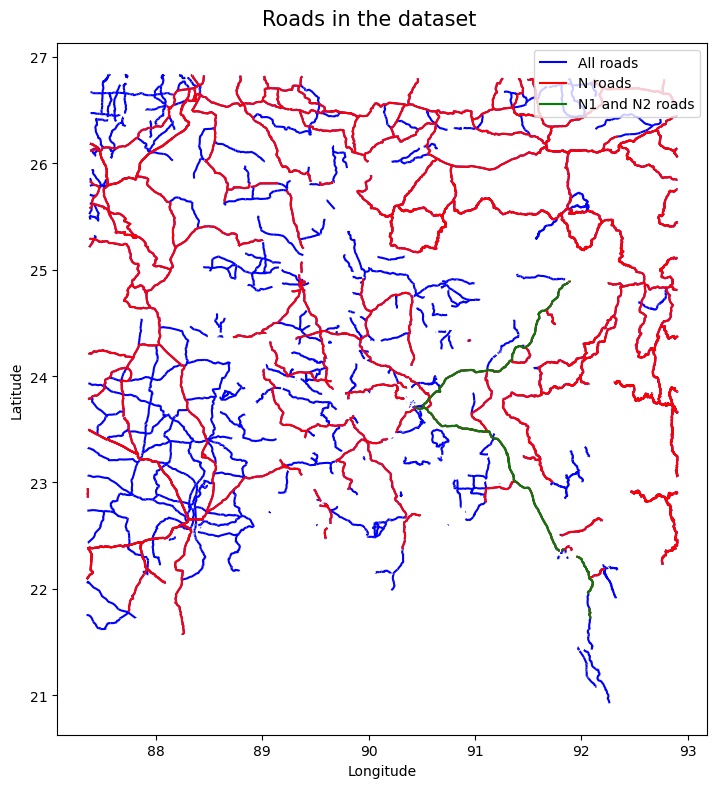

In [5]:
plot_roads(roads, 'All roads', 'Roads in the dataset', highlight=N_roads, highlight_label='N roads', highlight2=N1_N2, highlight_label2='N1 and N2 roads')

### Identification of the N roads with intersections to the N1 and N2

C:\Users\groen\AppData\Local\Temp\ipykernel_23072\3869394129.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  N1_N2['buffer_geom'] = N1_N2.geometry.buffer(buffer_distance)
C:\Users\groen\AppData\Local\Temp\ipykernel_23072\3869394129.py:8: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = N1_N2['buffer_geom'].unary_union
C:\Users\groen\AppData\Local\Temp\ipykernel_23072\3869394129.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roads_near_N1_N2.drop(N1_N2.index, inplace=True)
C:\Users\groen\AppData\Local\Temp\ipykernel_23072\3869394129.py:18: UserWarning: Legend does not support handles for P

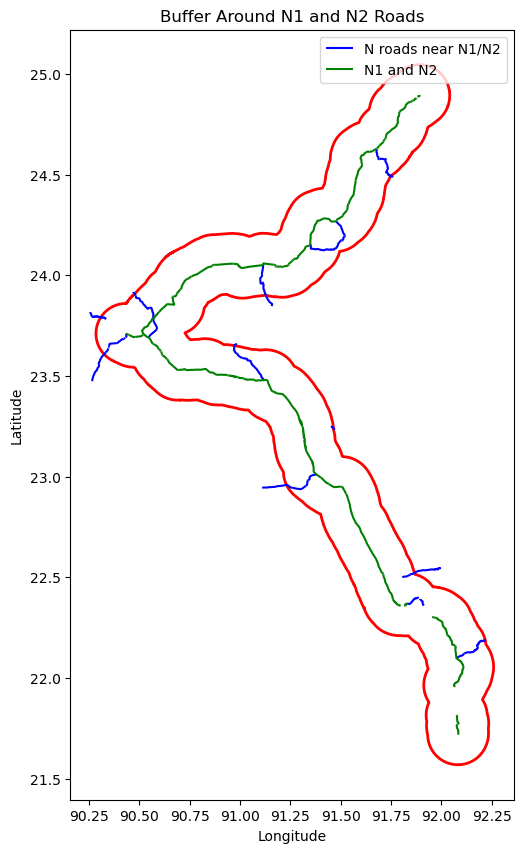

In [6]:
# Second step: identify the roads that are near the N1 and N2 roads

# 0. Create a buffer around N1 and N2 roads (buffer distance may need adjustment based on CRS units)
buffer_distance = 0.15  # Adjust this value as needed
N1_N2['buffer_geom'] = N1_N2.geometry.buffer(buffer_distance)

# 1. Combine all buffer geometries into a single geometry for ease of intersection check
buffer_union = N1_N2['buffer_geom'].unary_union

# 2. Identify roads that intersect the buffer of N1/N2 roads
roads_near_N1_N2 = N_roads[N_roads.geometry.intersects(buffer_union)]
roads_near_N1_N2.drop(N1_N2.index, inplace=True)

# Plot the roads and buffer to visualize the area of interest
ax = roads_near_N1_N2.plot(color='blue', figsize=(10, 10), label='N roads near N1/N2')
N1_N2.plot(ax=ax, color='green', label='N1 and N2')
gpd.GeoSeries(buffer_union).plot(ax=ax, color='none', edgecolor='red', linewidth=2, label='Buffer')
ax.legend()
plt.title("Buffer Around N1 and N2 Roads")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### Identify the intersections of the roads

In [7]:
# Third step: identify the crossroads

# Function to sample points along the N1/N2 roads
def sample_points_along_line(line, interval):
    if line.length == 0:
        return [line]
    num_points = int(np.ceil(line.length / interval))
    # Ensure we include the endpoint by using np.linspace over [0, length]
    distances = np.linspace(0, line.length, num_points+1)
    return [line.interpolate(distance) for distance in distances]

# 0. Define a small buffer around each point to check for intersections with other roads.
small_buffer_distance = 0.003
sampling_interval = 0.001

# 1. Iterate over each N1/N2 road segment and sample points along the road.
candidate_points = []
for idx_n, n1n2_row in N1_N2.iterrows():
    geom = n1n2_row.geometry
    # Sample points along this road segment
    points_on_road = sample_points_along_line(geom, sampling_interval)
    
    for pt in points_on_road:
        # Create a small buffer around the point.
        pt_buffer = pt.buffer(small_buffer_distance)
        
        # For each nearby road, check if its geometry (if not part of the same road) has any point within this small buffer.
        intersecting = False
        for idx_other, other_row in roads_near_N1_N2.iterrows():
            # Skip if the other road is the same as the current N1/N2 road (or adjust based on your criteria)
            if idx_n == idx_other:
                continue
            
            if other_row.geometry.intersects(pt_buffer):
                intersecting = True
                break
        
        # Only add candidate if the buffer around the point touches another road.
        if intersecting:
            candidate_points.append(pt)


At this point, candidate_points contains points along the N1/N2 roads that have are at least close to one other road. To consolidate multiple candidate points that belong to the same physical intersection, we use clustering (DBSCAN) and compute centroids of each cluster.


In [8]:
# 2. Perform clustering to identify crossroads  using DBSCAN
if candidate_points:
    coords = np.array([(p.x, p.y) for p in candidate_points])
    
    clustering = DBSCAN(eps=0.0005, min_samples=1).fit(coords)
    labels = clustering.labels_
    
    # Compute centroids for each cluster to represent a distinct crossroad
    crossroads = []
    for label in np.unique(labels):
        cluster_coords = coords[labels == label]
        centroid = cluster_coords.mean(axis=0)
        crossroads.append(Point(centroid))
else:
    crossroads = []

# Create a GeoDataFrame for the crossroads
crossroads_gdf = gpd.GeoDataFrame(geometry=crossroads, crs=N_roads.crs)


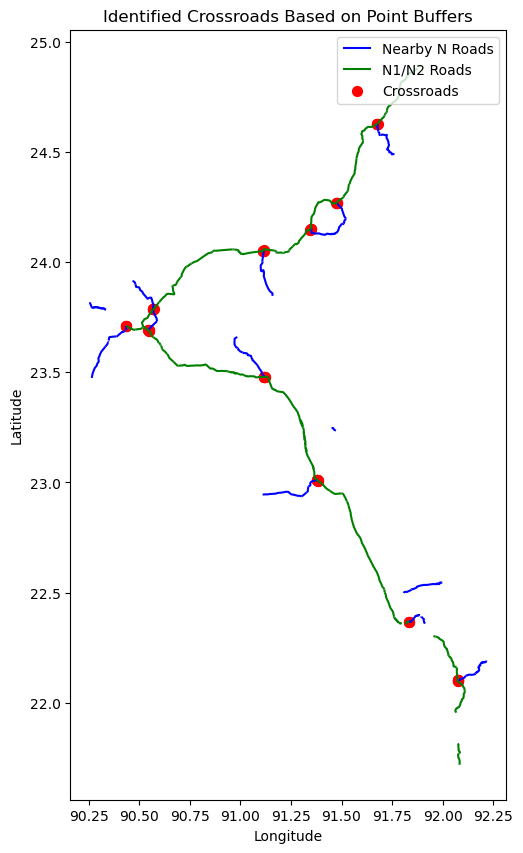

In [9]:
# Plot the roads, candidate points, and identified crossroads.
fig, ax = plt.subplots(figsize=(10, 10))
roads_near_N1_N2.plot(ax=ax, color='blue', label='Nearby N Roads')
N1_N2.plot(ax=ax, color='green', label='N1/N2 Roads')
crossroads_gdf.plot(ax=ax, color='red', markersize=50, label='Crossroads')
ax.legend()
plt.title("Identified Crossroads Based on Point Buffers")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


# Compare the new locations with the approximate locations used

In [10]:
file_path = '../data/final_n1_n2.csv'
approximate_crossroads = pd.read_csv(file_path)
approximate_crossroads = gpd.GeoDataFrame(approximate_crossroads, geometry=gpd.points_from_xy(approximate_crossroads['lon'], approximate_crossroads['lat']), crs='EPSG:32646')

approximate_crossroads = approximate_crossroads[approximate_crossroads['model_type'] == 'intersection']
approximate_crossroads

,road,id,model_type,condition,name,lat,lon,length,geometry
506,N1,1000506,intersection,NaN,Intersection with N104 / Km post missing,23.009556,91.381360,0.470,POINT (91.381 23.01)
2126,N102,1002126,intersection,NaN,Start of road from N1 Mainamati,23.478972,91.118194,0.000,POINT (91.118 23.479)
2453,N102,1002453,intersection,NaN,Meet with N 2 at Sanail,24.050611,91.114667,0.549,POINT (91.115 24.051)
2622,N105,1002622,intersection,NaN,"Starts of road from N1,Dhaka teknaf road at Ma...",23.690416,90.546611,0.000,POINT (90.547 23.69)
3002,N2,1003002,intersection,NaN,Road Start from N1 at Katchpur,23.705917,90.521444,0.000,POINT (90.521 23.706)
3022,N2,1003022,intersection,NaN,Intersection with N105,23.785333,90.568555,0.268,POINT (90.569 23.785)
4448,N204,1004448,intersection,NaN,Road start from N2 at Jagannathganj.,24.147916,91.346611,0.000,POINT (91.347 24.148)
4576,N204,1004576,intersection,NaN,Road End intersecting N2 at Shaistagonj Round ...,24.267388,91.477138,0.121,POINT (91.477 24.267)
4583,N207,1004583,intersection,NaN,Road start from N2 at Mirpur.,24.294861,91.510250,0.000,POINT (91.51 24.295)
4827,N207,1004827,intersection,NaN,Road end with N2 at Mukti joddha Chattor Sherpur.,24.626333,91.677527,0.350,POINT (91.678 24.626)


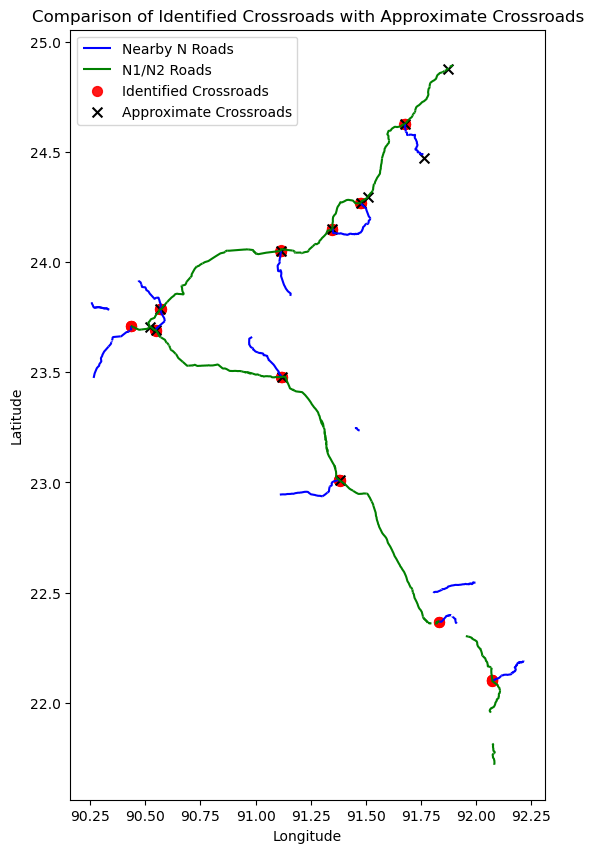

In [11]:
# Plot these locations next to the location of the crossroads we identified
fig, ax = plt.subplots(figsize=(10, 10))
roads_near_N1_N2.plot(ax=ax, color='blue', label='Nearby N Roads')
N1_N2.plot(ax=ax, color='green', label='N1/N2 Roads')
crossroads_gdf.plot(ax=ax, color='red', markersize=50, alpha=0.9, label='Identified Crossroads')
approximate_crossroads.plot(ax=ax, color='black', alpha=1, markersize=50, marker="x", label='Approximate Crossroads')

ax.legend()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')
plt.title('Comparison of Identified Crossroads with Approximate Crossroads')
plt.show()


In [12]:
# Calculate the distance between the identified crossroads and the approximate crossroads
crossroads_distances = []
for idx, row in approximate_crossroads.iterrows():
    point = row.geometry
    distances = crossroads_gdf.distance(point)
    min_distance = distances.min()
    crossroads_distances.append(min_distance)

approximate_crossroads['distance_to_identified'] = crossroads_distances
approximate_crossroads

C:\Users\groen\AppData\Local\Temp\ipykernel_23072\159391699.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distances = crossroads_gdf.distance(point)


,road,id,model_type,condition,name,lat,lon,length,geometry,distance_to_identified
506,N1,1000506,intersection,NaN,Intersection with N104 / Km post missing,23.009556,91.381360,0.470,POINT (91.381 23.01),0.000429
2126,N102,1002126,intersection,NaN,Start of road from N1 Mainamati,23.478972,91.118194,0.000,POINT (91.118 23.479),0.000283
2453,N102,1002453,intersection,NaN,Meet with N 2 at Sanail,24.050611,91.114667,0.549,POINT (91.115 24.051),0.000535
2622,N105,1002622,intersection,NaN,"Starts of road from N1,Dhaka teknaf road at Ma...",23.690416,90.546611,0.000,POINT (90.547 23.69),0.000253
3002,N2,1003002,intersection,NaN,Road Start from N1 at Katchpur,23.705917,90.521444,0.000,POINT (90.521 23.706),0.027365
3022,N2,1003022,intersection,NaN,Intersection with N105,23.785333,90.568555,0.268,POINT (90.569 23.785),0.000252
4448,N204,1004448,intersection,NaN,Road start from N2 at Jagannathganj.,24.147916,91.346611,0.000,POINT (91.347 24.148),0.000602
4576,N204,1004576,intersection,NaN,Road End intersecting N2 at Shaistagonj Round ...,24.267388,91.477138,0.121,POINT (91.477 24.267),0.000208
4583,N207,1004583,intersection,NaN,Road start from N2 at Mirpur.,24.294861,91.510250,0.000,POINT (91.51 24.295),0.041144
4827,N207,1004827,intersection,NaN,Road end with N2 at Mukti joddha Chattor Sherpur.,24.626333,91.677527,0.350,POINT (91.678 24.626),0.000579


## Reflection on the difference between the identified corssraods in the bonus assignment and the crossroads used in the rest of the assignment
 

`Altough discussed during the workshop on the third of March, to work on a theoretical difference between the locations, we, at that moment, misinterpretated the bonus assignment. Therefore, now we fixed this misinterpretation, we are able to discuss the differences between the intersection locations as used in the assignment, and the locations as identified in the bonus assignment`

`This text is also literally in the report`

#### Introduction
The accurate identification of road intersections is essential for modeling realistic vehicle movements in an agent-based model (ABM). However, for the learning process and experimentation, such accuracy is not strictly necessary. This text concisely discusses the differences between accurately identifying intersections using GeoPandas and shapefiles versus employing more coarse techniques to define intersection locations.

#### Comparison of the locations
An initial observation is that the identified crossroads and the approximate crossroads do not fully coincide. Based on the plotted map nd the accompanying DataFrame, several points appear to align reasonably well, while others are offset by varying degrees. These discrepancies are evident in the distance_to_identified column, where the planar distances are small for some points but never exactly zero. This indicates that even intersections that seem visually close on the map can still differ numerically when precise spatial calculations are performed.

These differences occur do the the different approaches used and the margins used. While the intersection points in the assignment are based on the csv file, in this bonus assignemt we base them on the geospacial intersection using a buffer zone around each point on the N1 and N2, with a sampling interval of 0.001. After this, we perform a spatial clustering using DBSCAN to identify the centroids for each cluster which intersects with another road. 


#### Impact on the experimental outcome
In an agent-based model, inaccurate distance calculations can lead to unrealistic movements of the vehicles as agents may (this differs based on how your set-up of the model is) take suboptimal routes. This leads to incorrect clustering of agents at certain intersections or unrealistic gaps in traffic flow. Furthermore, if the model incorporates speed limits or fuel consumption estimates based on travel distance, these inaccuracies can propagate throughout the simulation, leading to unreliable results. 

On the other hand, for the practical functioning of an agent-based model, precise locations of intersections are not necessarily relevant, as it mainly, and only, affects the accuracy of, and realisticness of, the model.
